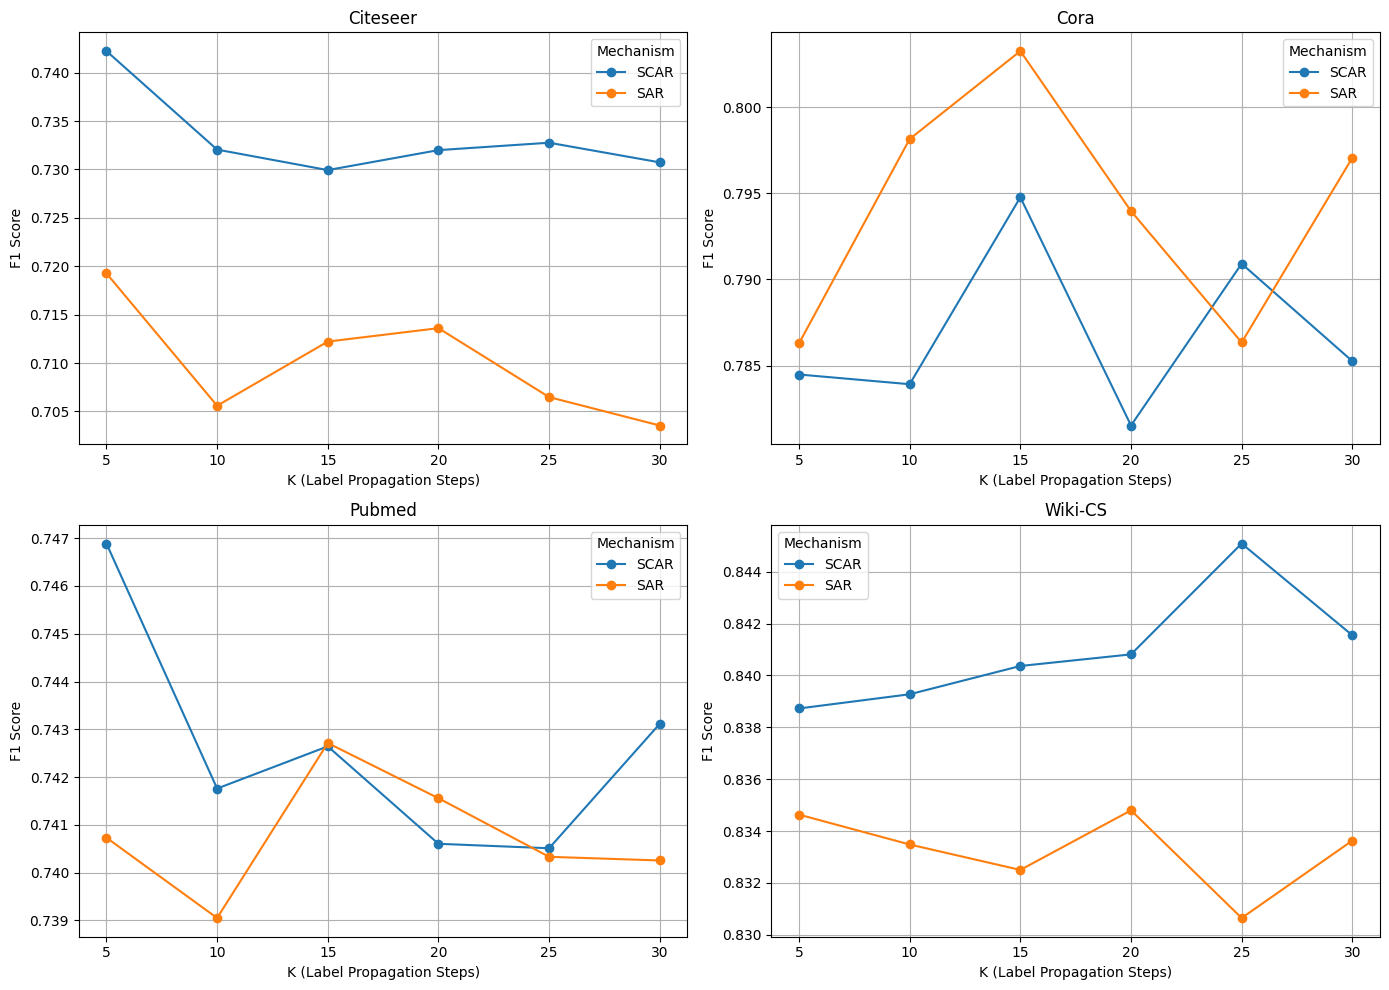

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv(r"C:\Users\Romain\OneDrive - KU Leuven\Github thesis\gnn_pu\gnn_pu\NNIF-GNN\OutputData\ours_experiments_vary_K_pollution.csv")

df = pd.DataFrame(data)
datasets = df['dataset'].unique()
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, dataset in enumerate(datasets):
    ax = axs[i]
    for mechanism in ['SCAR', 'SAR']:
        subset = df[(df['dataset'] == dataset) & (df['mechanism'] == mechanism)].sort_values('K')
        ax.errorbar(subset['K'], subset['avg_f1'],# yerr=subset['std_f1'],
                    label=mechanism, marker='o', capsize=4, linestyle='-')
    if dataset == 'wiki-cs':
        dataset = 'Wiki-CS'
    else:
        dataset = dataset.capitalize()
    ax.set_title(f'{dataset}')
    ax.set_xlabel('K (Label Propagation Steps)')
    ax.set_ylabel('F1 Score')
    ax.grid(True)
    ax.legend(title='Mechanism')

plt.tight_layout()
plt.savefig(r"C:\Users\Romain\OneDrive - KU Leuven\Github thesis\gnn_pu\gnn_pu\NNIF-GNN\ours_experiments_vary_K_pollution.png")
plt.show()



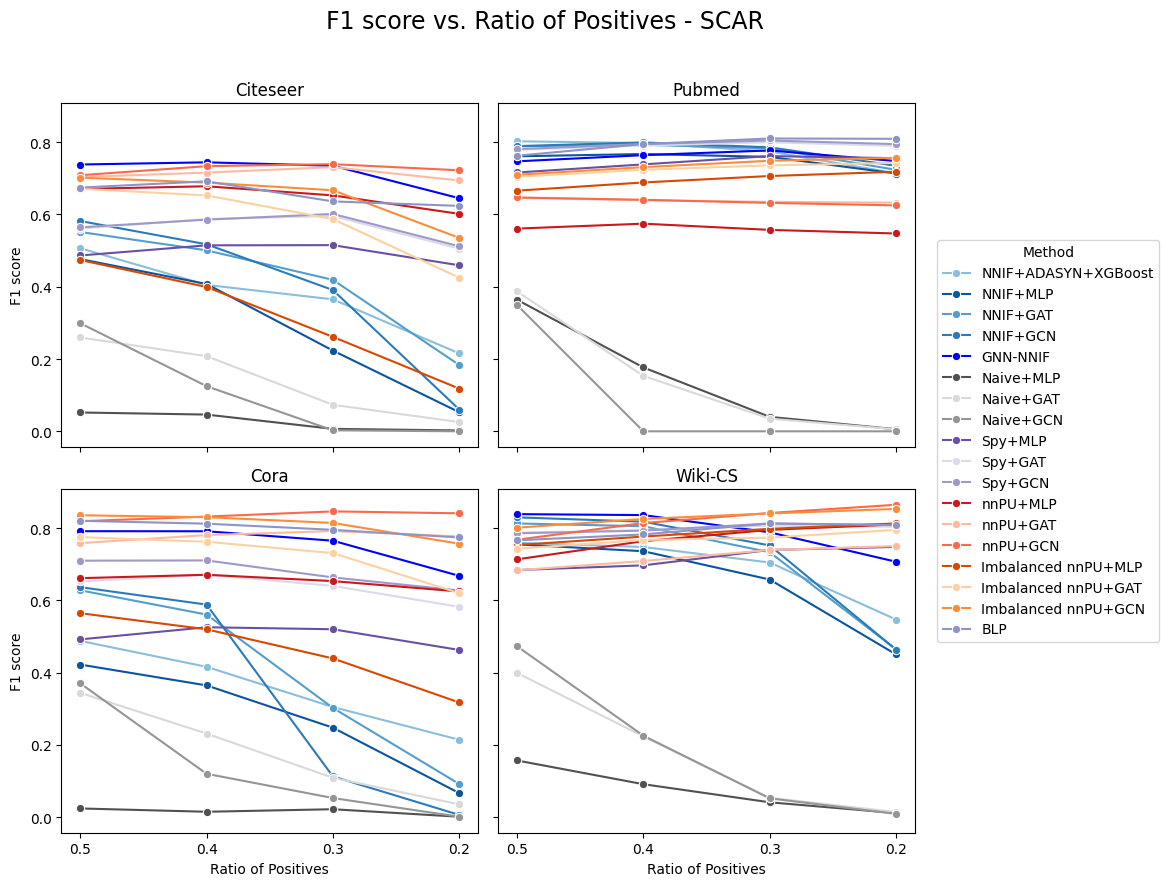

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ──── 1. Load & label data ─────────────────────────────────────────────────────
file_path = r"C:\Users\Romain\OneDrive - KU Leuven\Github thesis\gnn_pu\gnn_pu\NNIF-GNN\OutputData\data_train_pct_corrected_2.csv"
df = pd.read_csv(file_path)

def format_methodology(row):
    if row['methodology'] == 'NNIF':
        return 'NNIF+ADASYN+XGBoost'
    if row['methodology'] == 'two_nnif':
        return f"NNIF+{row['model_type'].replace('Conv','')}"
    if row['methodology'] == 'nnpu':
        return f"nnPU+{row['model_type'].replace('Conv','')}"
    if row['methodology'] == 'imbnnpu':
        return f"Imbalanced nnPU+{row['model_type'].replace('Conv','')}"
    if row['methodology'] == 'naive':
        return f"Naive+{row['model_type'].replace('Conv','')}"
    if row['methodology'] == 'spy':
        return f"Spy+{row['model_type'].replace('Conv','')}"
    if row['methodology'] == 'ours':
        return "GNN-NNIF"
    if row['methodology'] == 'BLP':
        return "BLP"
    return row['methodology']

df['method_label'] = df.apply(format_methodology, axis=1)

# ──── 2. Assign each label to a family ──────────────────────────────────────────
def family_of(label):
    if label.startswith('Naive'):
        return 'Naive'
    if label.startswith('Spy'):
        return 'Spy'
    if label.startswith('NNIF'):
        return 'NNIF'
    if label == 'GNN-NNIF':
        return 'GNN-NNIF'
    if label.startswith('Imbalanced nnPU'):
        return 'Imbalanced nnPU'
    if label.startswith('nnPU'):
        return 'nnPU'
    if label.startswith('BLP'):
        return 'BLP'
    return 'Other'

df['family'] = df['method_label'].map(family_of)

# ──── 3. Build per-family sub-palettes ─────────────────────────────────────────
palette_by_family = {}
for fam, group in df.groupby('family'):
    n = group['method_label'].nunique()
    if fam in ['BLP']:
        # Blues: from light to dark
        palette_by_family[fam] = sns.color_palette("BuPu", n_colors=n)
    elif fam in ['Spy']:
        # Blues: from light to dark
        palette_by_family[fam] = sns.color_palette("Purples", n_colors=n)
    elif fam in ['NNIF']:
        # Greens
        palette_by_family[fam] = sns.color_palette("Blues", n_colors=n+2)
    elif fam in ['GNN-NNIF']:
        # Greens
        palette_by_family[fam] = sns.color_palette("YlGnBu", n_colors=n)
    elif fam in ['nnPU']:
        # Greens
        palette_by_family[fam] = sns.color_palette("Reds", n_colors=n)
    elif fam in ['Imbalanced nnPU']:
        # Greens
        palette_by_family[fam] = sns.color_palette("Oranges", n_colors=n)
    elif fam == 'Naive':
        # Oranges
        palette_by_family[fam] = sns.color_palette("Greys", n_colors=n)
    else:
        palette_by_family[fam] = sns.color_palette("Greys", n_colors=n)

# Now map each method_label → a distinct colour from its family palette
custom_palette = {}
for fam, colors in palette_by_family.items():
    labels = sorted(df[df['family']==fam]['method_label'].unique())
    if fam == 'NNIF':
        colors = colors[2:]
    for lab, col in zip(labels, colors):
        custom_palette[lab] = col
        if fam=='GNN-NNIF':
            custom_palette[lab] = "Blue"

# ──── 4. Plot with the hierarchical palette ────────────────────────────────────
mechanisms = ['SCAR']
datasets   = ['citeseer','cora','pubmed','wiki-cs']

fig, axes = plt.subplots(2, 2, figsize=(11, 9), sharex=True, sharey=True)
axes = axes.reshape(2, 2)
handles = labels = None

for idx, dset in enumerate(datasets):
    r = idx % 2
    c = idx // 2
    ax = axes[r, c]
    sub = df[(df['dataset']==dset) & (df['mechanism']=='SCAR')]

    show_legend = (r==0 and c==0)
    sns.lineplot(
        data=sub,
        x='train_pct', y='avg_f1',
        hue='method_label',
        palette=custom_palette,
        marker='o',
        ax=ax,
        legend=show_legend
    )

    title = "Wiki-CS" if dset=="wiki-cs" else dset.capitalize()
    ax.set_title(title)
    ax.set_xlabel("Ratio of Positives")
    ax.set_ylabel("F1 score")

    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()

fig.legend(
    handles, labels,
    title="Method",
    loc="center left",
    bbox_to_anchor=(0.85, 0.5)
)
fig.suptitle("F1 score vs. Ratio of Positives - SCAR", fontsize=17)
fig.tight_layout(rect=[0, 0, 0.85, 0.96])
xticks = sorted(df['train_pct'].unique(), reverse=True)

# 2) set them on each subplot
for ax in axes.flatten():
    ax.set_xticks(xticks)
plt.gca().invert_xaxis()
plt.savefig(rf"C:\Users\Romain\OneDrive - KU Leuven\Github thesis\gnn_pu\gnn_pu\NNIF-GNN\figures\SCAR_2x2_train_pct.png", dpi=300, bbox_inches='tight')
plt.show()


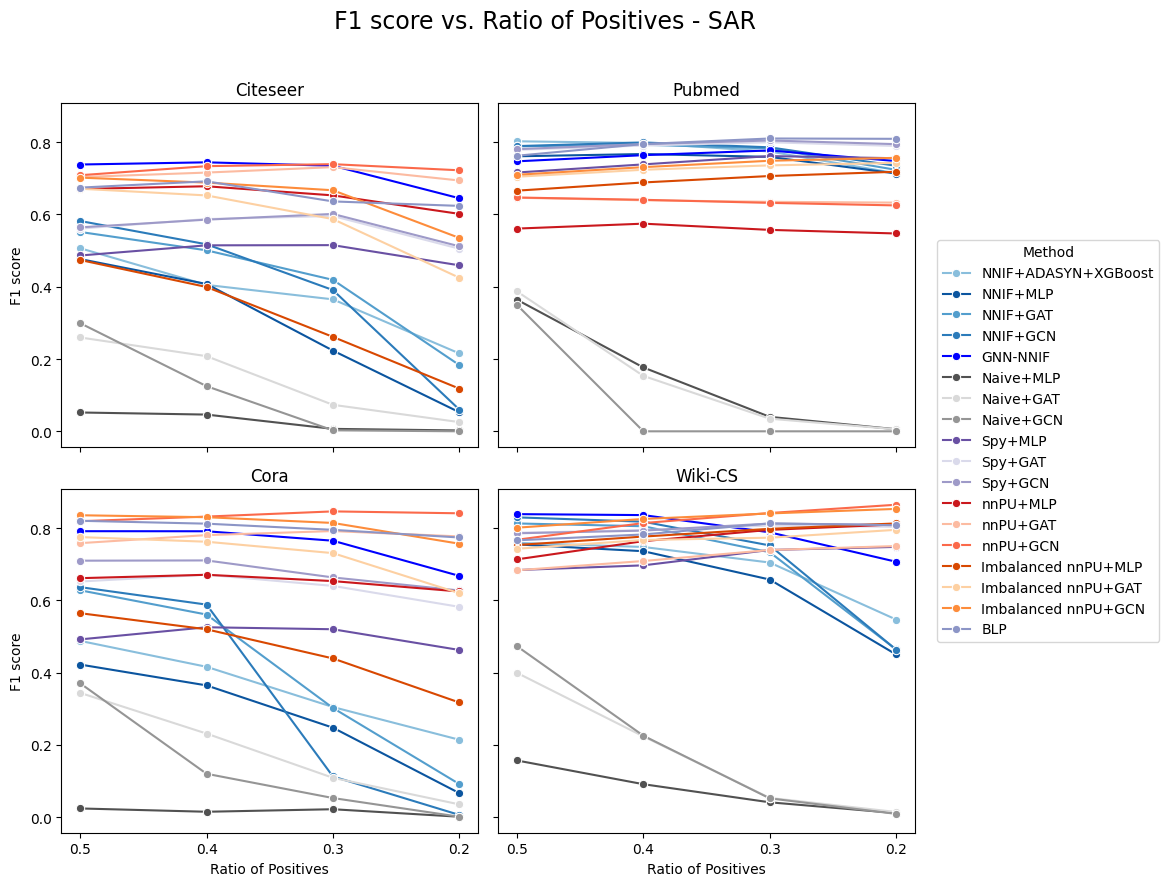

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ──── 1. Load & label data ─────────────────────────────────────────────────────
file_path = r"C:\Users\Romain\OneDrive - KU Leuven\Github thesis\gnn_pu\gnn_pu\NNIF-GNN\OutputData\data_train_pct_corrected_2.csv"
df = pd.read_csv(file_path)

def format_methodology(row):
    if row['methodology'] == 'NNIF':
        return 'NNIF+ADASYN+XGBoost'
    if row['methodology'] == 'two_nnif':
        return f"NNIF+{row['model_type'].replace('Conv','')}"
    if row['methodology'] == 'nnpu':
        return f"nnPU+{row['model_type'].replace('Conv','')}"
    if row['methodology'] == 'imbnnpu':
        return f"Imbalanced nnPU+{row['model_type'].replace('Conv','')}"
    if row['methodology'] == 'naive':
        return f"Naive+{row['model_type'].replace('Conv','')}"
    if row['methodology'] == 'spy':
        return f"Spy+{row['model_type'].replace('Conv','')}"
    if row['methodology'] == 'ours':
        return "GNN-NNIF"
    if row['methodology'] == 'BLP':
        return "BLP"
    return row['methodology']

df['method_label'] = df.apply(format_methodology, axis=1)

# ──── 2. Assign each label to a family ──────────────────────────────────────────
def family_of(label):
    if label.startswith('Naive'):
        return 'Naive'
    if label.startswith('Spy'):
        return 'Spy'
    if label.startswith('NNIF'):
        return 'NNIF'
    if label == 'GNN-NNIF':
        return 'GNN-NNIF'
    if label.startswith('Imbalanced nnPU'):
        return 'Imbalanced nnPU'
    if label.startswith('nnPU'):
        return 'nnPU'
    if label.startswith('BLP'):
        return 'BLP'
    return 'Other'

df['family'] = df['method_label'].map(family_of)

# ──── 3. Build per-family sub-palettes ─────────────────────────────────────────
palette_by_family = {}
for fam, group in df.groupby('family'):
    n = group['method_label'].nunique()
    if fam in ['BLP']:
        # Blues: from light to dark
        palette_by_family[fam] = sns.color_palette("BuPu", n_colors=n)
    elif fam in ['Spy']:
        # Blues: from light to dark
        palette_by_family[fam] = sns.color_palette("Purples", n_colors=n)
    elif fam in ['NNIF']:
        # Greens
        palette_by_family[fam] = sns.color_palette("Blues", n_colors=n+2)
    elif fam in ['GNN-NNIF']:
        # Greens
        palette_by_family[fam] = sns.color_palette("YlGnBu", n_colors=n)
    elif fam in ['nnPU']:
        # Greens
        palette_by_family[fam] = sns.color_palette("Reds", n_colors=n)
    elif fam in ['Imbalanced nnPU']:
        # Greens
        palette_by_family[fam] = sns.color_palette("Oranges", n_colors=n)
    elif fam == 'Naive':
        # Oranges
        palette_by_family[fam] = sns.color_palette("Greys", n_colors=n)
    else:
        palette_by_family[fam] = sns.color_palette("Greys", n_colors=n)

# Now map each method_label → a distinct colour from its family palette
custom_palette = {}
for fam, colors in palette_by_family.items():
    labels = sorted(df[df['family']==fam]['method_label'].unique())
    if fam == 'NNIF':
        colors = colors[2:]
    for lab, col in zip(labels, colors):
        custom_palette[lab] = col
        if fam=='GNN-NNIF':
            custom_palette[lab] = "Blue"

# ──── 4. Plot with the hierarchical palette ────────────────────────────────────
mechanisms = ['SAR']
datasets   = ['citeseer','cora','pubmed','wiki-cs']

fig, axes = plt.subplots(2, 2, figsize=(11, 9), sharex=True, sharey=True)
axes = axes.reshape(2, 2)
handles = labels = None

for idx, dset in enumerate(datasets):
    r = idx % 2
    c = idx // 2
    ax = axes[r, c]
    sub = df[(df['dataset']==dset) & (df['mechanism']=='SCAR')]

    show_legend = (r==0 and c==0)
    sns.lineplot(
        data=sub,
        x='train_pct', y='avg_f1',
        hue='method_label',
        palette=custom_palette,
        marker='o',
        ax=ax,
        legend=show_legend
    )

    title = "Wiki-CS" if dset=="wiki-cs" else dset.capitalize()
    ax.set_title(title)
    ax.set_xlabel("Ratio of Positives")
    ax.set_ylabel("F1 score")

    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()

fig.legend(
    handles, labels,
    title="Method",
    loc="center left",
    bbox_to_anchor=(0.85, 0.5)
)
fig.suptitle("F1 score vs. Ratio of Positives - SAR", fontsize=17)
fig.tight_layout(rect=[0, 0, 0.85, 0.96])
xticks = sorted(df['train_pct'].unique(), reverse=True)

# 2) set them on each subplot
for ax in axes.flatten():
    ax.set_xticks(xticks)
plt.gca().invert_xaxis()
plt.savefig(rf"C:\Users\Romain\OneDrive - KU Leuven\Github thesis\gnn_pu\gnn_pu\NNIF-GNN\figures\SAR_2x2_train_pct.png", dpi=300, bbox_inches='tight')
plt.show()


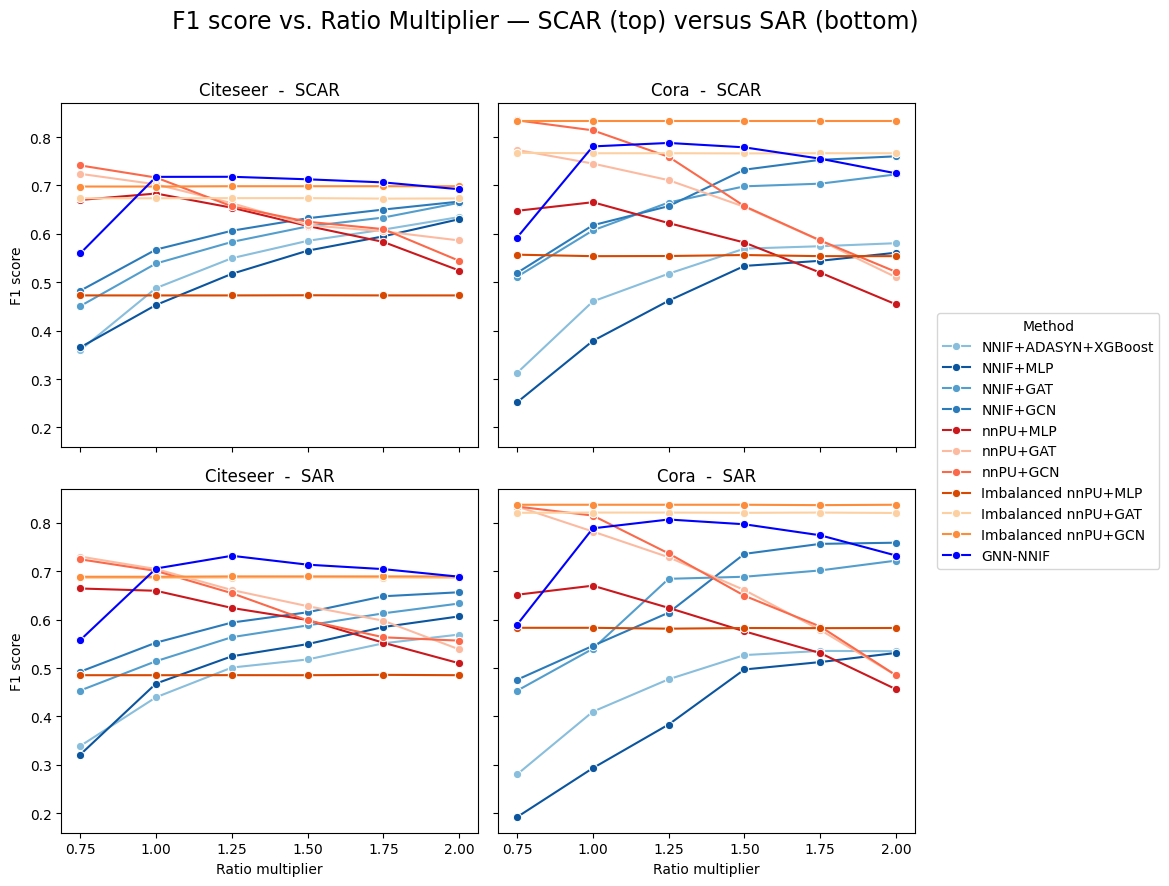

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#───────────────────── 1.  Load & label data
file_path = r"C:\Users\Romain\OneDrive - KU Leuven\Github thesis\gnn_pu\gnn_pu\NNIF-GNN\OutputData\varying_prior_pollution_results.csv"
df = pd.read_csv(file_path)

def format_methodology(row):
    if row['methodology'] == 'NNIF':
        return 'NNIF+ADASYN+XGBoost'
    if row['methodology'] == 'two_nnif':

        return f"NNIF+{row['model_type'].replace('Conv','')}"  # Remove 'Conv' from the model type
    if row['methodology'] == 'nnpu':
        return f"nnPU+{row['model_type'].replace('Conv','')}"
    if row['methodology'] == 'imbnnpu':
        return f"Imbalanced nnPU+{row['model_type'].replace('Conv','')}"
    if row['methodology'] == 'ours':
        return "GNN-NNIF"
    return row['methodology']

df['method_label'] = df.apply(format_methodology, axis=1)

# ──── 2. Assign each label to a family ──────────────────────────────────────────
def family_of(label):
    if label.startswith('Naive'):
        return 'Naive'
    if label.startswith('Spy'):
        return 'Spy'
    if label.startswith('NNIF'):
        return 'NNIF'
    if label == 'GNN-NNIF':
        return 'GNN-NNIF'
    if label.startswith('Imbalanced nnPU'):
        return 'Imbalanced nnPU'
    if label.startswith('nnPU'):
        return 'nnPU'
    if label.startswith('BLP'):
        return 'BLP'
    return 'Other'

df['family'] = df['method_label'].map(family_of)

# ──── 3. Build per-family sub-palettes ─────────────────────────────────────────
palette_by_family = {}
for fam, group in df.groupby('family'):
    n = group['method_label'].nunique()
    if fam in ['BLP']:
        # Blues: from light to dark
        palette_by_family[fam] = sns.color_palette("BuPu", n_colors=n)
    elif fam in ['Spy']:
        # Blues: from light to dark
        palette_by_family[fam] = sns.color_palette("Purples", n_colors=n)
    elif fam in ['NNIF']:
        # Greens
        palette_by_family[fam] = sns.color_palette("Blues", n_colors=n+2)
    elif fam in ['GNN-NNIF']:
        # Greens
        palette_by_family[fam] = sns.color_palette("YlGnBu", n_colors=n)
    elif fam in ['nnPU']:
        # Greens
        palette_by_family[fam] = sns.color_palette("Reds", n_colors=n)
    elif fam in ['Imbalanced nnPU']:
        # Greens
        palette_by_family[fam] = sns.color_palette("Oranges", n_colors=n)
    elif fam == 'Naive':
        # Oranges
        palette_by_family[fam] = sns.color_palette("Greys", n_colors=n)
    else:
        palette_by_family[fam] = sns.color_palette("Greys", n_colors=n)

# Now map each method_label → a distinct colour from its family palette
custom_palette = {}
for fam, colors in palette_by_family.items():
    labels = sorted(df[df['family']==fam]['method_label'].unique())
    if fam == 'NNIF':
        colors = colors[2:]
    for lab, col in zip(labels, colors):
        custom_palette[lab] = col
        if fam=='GNN-NNIF':
            custom_palette[lab] = "Blue"
   
#───────────────────── 2.  Plot: 2 × 2 grid  (SCAR ↑ , SAR ↓)
mechanisms = ['SCAR', 'SAR']          # rows
datasets   = ['citeseer', 'cora']     # columns

fig, axes = plt.subplots(2, 2, figsize=(11, 9), sharex=True, sharey=True)
axes = axes.reshape(2, 2)
handles = labels = None


for r, mech in enumerate(mechanisms):
    for c, dset in enumerate(datasets):
        ax = axes[r, c]
        sub = df[(df['dataset'] == dset) & (df['mechanism'] == mech)]


        # only the first panel (r==0 & c==0) keeps its legend
        show_local_legend = (r == 0 and c == 0)

        sns.lineplot(
            data=sub,
            x='ratio_multiplier', y='avg_f1',
            hue='method_label', 
            palette=custom_palette,
            marker='o',
            ax=ax,
            legend=show_local_legend          # let Seaborn build ONE legend
        )
        
        if mech== 'SCAR':
            mechanism = 'SCAR'
        else:
            mechanism = 'SAR'

        ax.set_title(f"{dset.capitalize()}  -  {mechanism}")
        ax.set_xlabel("Ratio multiplier")
        ax.set_ylabel("F1 score")

        if show_local_legend:                 # harvest its entries
            handles, labels = ax.get_legend_handles_labels()
            ax.get_legend().remove()          # and hide the local legend

#───────────────────── 3.  Global legend   &  layout
fig.legend(
    handles, labels,
    title="Method", loc="center left",
    bbox_to_anchor=(0.85, 0.5)
)
fig.suptitle("F1 score vs. Ratio Multiplier — SCAR (top) versus SAR (bottom)",fontsize=17)
fig.tight_layout(rect=[0, 0, 0.85, 0.96])   # leave room for legend & title
xticks = sorted(df['ratio_multiplier'].unique(), reverse=True)

# 2) set them on each subplot
for ax in axes.flatten():
    ax.set_xticks(xticks)
# Optional: save & show
out = r"C:\Users\Romain\OneDrive - KU Leuven\Github thesis\gnn_pu\gnn_pu\NNIF-GNN\figures\scar_sar_2x2_citeseer_cora.png"
fig.savefig(out, dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)  # Close the figure to free up memory